<a href="https://colab.research.google.com/github/derek-shing/DS-Unit-4-Sprint-4-Deep-Learning/blob/master/LS_DS_Unit_4_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

## *Data Science Unit 4 Sprint 4*

# Sprint Challenge
### RNNs, CNNs, GANS, and AutoML

In this Sprint Challenge, you'll explore some of the cutting edge of Data Science. *Caution* - these approaches can be pretty heavy computationally. All problems are designed to completed with 5-10 minutes of run time on most machines. If you approach takes longer, please double check your work. 

## Part 1 - RNNs

Use an RNN to fit a classification model on tweets to distinguish from tweets from any two accounts. The following code sample illustrates how to access data from an account (no API auth needed, uses [twitterscraper](https://github.com/taspinar/twitterscraper): 

In [1]:
!pip install twitterscraper

  Stored in directory: /root/.cache/pip/wheels/45/50/9b/70128bca07e2bf8b5ed3f504002e9e74a6eaa5e756341b6931
Successfully built twitterscraper


In [4]:
from twitterscraper import query_tweets

austen_tweets = query_tweets('from:austen',1000)
len(austen_tweets)

INFO: queries: ['from:austen since:2006-03-21 until:2006-11-16', 'from:austen since:2006-11-16 until:2007-07-14', 'from:austen since:2007-07-14 until:2008-03-10', 'from:austen since:2008-03-10 until:2008-11-06', 'from:austen since:2008-11-06 until:2009-07-04', 'from:austen since:2009-07-04 until:2010-03-01', 'from:austen since:2010-03-01 until:2010-10-27', 'from:austen since:2010-10-27 until:2011-06-25', 'from:austen since:2011-06-25 until:2012-02-20', 'from:austen since:2012-02-20 until:2012-10-17', 'from:austen since:2012-10-17 until:2013-06-14', 'from:austen since:2013-06-14 until:2014-02-10', 'from:austen since:2014-02-10 until:2014-10-08', 'from:austen since:2014-10-08 until:2015-06-05', 'from:austen since:2015-06-05 until:2016-01-31', 'from:austen since:2016-01-31 until:2016-09-28', 'from:austen since:2016-09-28 until:2017-05-26', 'from:austen since:2017-05-26 until:2018-01-21', 'from:austen since:2018-01-21 until:2018-09-18', 'from:austen since:2018-09-18 until:2019-05-17']
INFO

181

In [5]:
austen_tweets[0].text

'I love love love working with great people.pic.twitter.com/fCKOm6Vl'

Your Tasks:
* Select two twitter accounts to gather data from
* Use twitterscraper to get ~1,000 tweets from each account
* Encode the characters to a sequence of integers for the model
* Get the data into the appropriate shape/format, including labels and a train/test split
* Use Keras to fit a predictive model, classying tweets as being from one acount or the other
* Report your overall score and accuracy

For reference, the [Keras IMDB classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well as the RNN code we used in class.

Note - focus on getting a running model, not on making accuracy with extreme data size or epoch numbers. Fit a baseline model based on tweet text. Only revisit and push accuracy or incorporate additional features if you get everything else done!

In [6]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
tweets = [tweet.text for tweet in austen_tweets]

In [9]:
trump_tweets = query_tweets('from:POTUS', 1000)
len(trump_tweets)

INFO: queries: ['from:POTUS since:2006-03-21 until:2006-11-16', 'from:POTUS since:2006-11-16 until:2007-07-14', 'from:POTUS since:2007-07-14 until:2008-03-10', 'from:POTUS since:2008-03-10 until:2008-11-06', 'from:POTUS since:2008-11-06 until:2009-07-04', 'from:POTUS since:2009-07-04 until:2010-03-01', 'from:POTUS since:2010-03-01 until:2010-10-27', 'from:POTUS since:2010-10-27 until:2011-06-25', 'from:POTUS since:2011-06-25 until:2012-02-20', 'from:POTUS since:2012-02-20 until:2012-10-17', 'from:POTUS since:2012-10-17 until:2013-06-14', 'from:POTUS since:2013-06-14 until:2014-02-10', 'from:POTUS since:2014-02-10 until:2014-10-08', 'from:POTUS since:2014-10-08 until:2015-06-05', 'from:POTUS since:2015-06-05 until:2016-01-31', 'from:POTUS since:2016-01-31 until:2016-09-28', 'from:POTUS since:2016-09-28 until:2017-05-26', 'from:POTUS since:2017-05-26 until:2018-01-21', 'from:POTUS since:2018-01-21 until:2018-09-18', 'from:POTUS since:2018-09-18 until:2019-05-17']
INFO: Querying from:POTU

122

In [0]:
tweets = tweets +[tweet.text for tweet in trump_tweets]

In [11]:
len(tweets)

303

In [0]:
y = np.zeros(len(tweets))
y[:len(austen_tweets)] = 1

In [14]:
all=''
for tweet in tweets:
  all= all+ tweet

chars = list(set(all)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(tweets)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)

unique characters :  121
txt_data_size :  303


In [15]:
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
X=[]
for tweet in tweets:
  integer_encoded = [char_to_int[i] for i in tweet] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
  X.append(integer_encoded)
  
X = sequence.pad_sequences(X, maxlen=280)

{'л': 0, 't': 1, 'r': 2, '-': 3, 'В': 4, '"': 5, 'E': 6, 'p': 7, 'н': 8, 'x': 9, 'а': 10, 'b': 11, '7': 12, 'R': 13, '3': 14, 'ь': 15, 'N': 16, '8': 17, 'l': 18, 'd': 19, '0': 20, 'W': 21, 'h': 22, 'e': 23, '5': 24, 'X': 25, 'Т': 26, 'k': 27, 'A': 28, 'J': 29, 'т': 30, '.': 31, 'z': 32, 'К': 33, 'H': 34, ':': 35, '<': 36, '/': 37, '_': 38, 'п': 39, '6': 40, '(': 41, 'K': 42, 'a': 43, 'g': 44, '~': 45, 'Y': 46, 'в': 47, 'y': 48, 'з': 49, ',': 50, 'S': 51, 'У': 52, '…': 53, '>': 54, 'u': 55, '1': 56, '$': 57, '”': 58, '%': 59, 'G': 60, '^': 61, '“': 62, 'D': 63, 'э': 64, '’': 65, 'у': 66, 'v': 67, '@': 68, 'е': 69, 's': 70, '?': 71, ')': 72, 'P': 73, '*': 74, 'д': 75, '2': 76, 'х': 77, 'ж': 78, 'о': 79, 'г': 80, 'T': 81, 'V': 82, '4': 83, 'F': 84, 'с': 85, ' ': 86, '#': 87, 'M': 88, 'Q': 89, 'р': 90, 'L': 91, '&': 92, 'o': 93, "'": 94, 'c': 95, 'B': 96, '\n': 97, 'j': 98, '!': 99, 'ю': 100, 'w': 101, ';': 102, 'n': 103, 'я': 104, '9': 105, 'Z': 106, 'm': 107, '+': 108, '\xa0': 109, '=': 

In [0]:
X_train , X_test, y_train, y_test=train_test_split(X,y, test_size=0.1)

In [17]:
len(X_train)
len(X_test)

31

In [18]:
print('Build model...')
model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
batch_size = 32
print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
272/272 [==============================] - 8s 30ms/step - loss: 0.6702 - acc: 0.6250
Epoch 2/15
272/272 [==============================] - 6s 22ms/step - loss: 0.5689 - acc: 0.6507
Epoch 3/15
272/272 [==============================] - 6s 23ms/step - loss: 0.4712 - acc: 0.8199
Epoch 4/15
272/272 [==============================] - 6s 22ms/step - loss: 0.4228 - acc: 0.8272
Epoch 5/15
272/272 [==============================] - 6s 23ms/step - loss: 0.3825 - acc: 0.8346
Epoch 6/15
272/272 [==============================] - 6s 23ms/step - loss: 0.3662 - acc: 0.8456
Epoch 7/15
272/272 [==============================] - 6s 22ms/step - loss: 0.3662 - acc: 0.8603
Epoch 8/15
272/272 [==============================] - 6s 23ms/step - loss: 0.3134 - acc: 0.8713
Epoch 9/15
272/272 [==============================] - 6s 22ms/step - loss: 0.2838 - acc: 0.8860
Epoch 10/15
272/272 [==============================] - 6s 23ms/step - loss: 0.2

## Part 2 - CNNs
Time to play "find the frog!" Use Keras and ResNet50 to detect which of the following images contain frogs:

In [20]:
!pip install google_images_download

     |████████████████████████████████| 911kB 7.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/22/f3/7b/d1d7a18d9784458622ef3f9702c0bdbc179b431adde169c1a0
Successfully built google-images-download


In [35]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
arguments = {'keywords': "animal pond", "limit": 6, "print_urls": True}
absolute_image_paths = response.download(arguments)



Item no.: 1 --> Item name = animal pond
Evaluating...
Starting Download...
Image URL: https://www.enchantedlearning.com/pgifs/Pondanimals.GIF
Completed Image ====> 1.Pondanimals.GIF
Image URL: https://i.ytimg.com/vi/NCbu0TND9vE/hqdefault.jpg
Completed Image ====> 2.hqdefault.jpg
Image URL: https://get.pxhere.com/photo/water-animal-pond-wildlife-mammal-fish-eat-fauna-whiskers-vertebrate-otter-mink-marmot-sea-otter-mustelidae-1383482.jpg
Completed Image ====> 3.water-animal-pond-wildlife-mammal-fish-eat-fauna-whiskers-vertebrate-otter-mink-marmot-sea-otter-mustelidae-1383482.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116_inline.png
Completed Image ====> 4.PKLS4116_inline.png
Image URL: http://images.animalpicturesociety.com/images/5d/alligator_animal_on_pond.jpg
Completed Image ====> 5.alligator_animal_on_pond.jpg
Image URL: https://cdn.pixabay.com/photo/2017/04/19/20/37/frog-2243543_960_720.jpg
Completed Image ====> 6.frog-2243543_960_720.jpg

Errors: 0



At the time of writing at least a few do, but since the internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is validly run ResNet50 on the input images - don't worry about tuning or improving the model. 

*Hint:* ResNet 50 doesn't just return "frog". The three labels it has for frogs are bullfrog, tree frog, and tailed frog.

Stretch goal - also check for fish.

In [0]:
from PIL import Image, ImageOps
import imageio
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [0]:
def process_img_path(img_path):
  return image.load_img(img_path, target_size=(224, 224))

def img_contains_frog(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  model = ResNet50(weights='imagenet')
  features = model.predict(x)
  results = decode_predictions(features, top=3)[0]
  print(results)
  target =['bullfrog', 'tree frog', 'tailed frog']
  for entry in results:
    if entry[1] in target:
      return entry[2]
  return 0.0

In [43]:
for path in absolute_image_paths[0]['animal pond']:
  if img_contains_frog(process_img_path(path))>0:
    Image.open(path)

[('n03598930', 'jigsaw_puzzle', 0.86803216), ('n06359193', 'web_site', 0.06409976), ('n02834397', 'bib', 0.021264203)]
[('n01443537', 'goldfish', 0.849588), ('n01631663', 'eft', 0.06760151), ('n02536864', 'coho', 0.03516323)]
[('n02442845', 'mink', 0.30976495), ('n02363005', 'beaver', 0.23399015), ('n02361337', 'marmot', 0.20796911)]
[('n04243546', 'slot', 0.8712441), ('n04476259', 'tray', 0.04993626), ('n03908618', 'pencil_box', 0.023072539)]
[('n01698640', 'American_alligator', 0.96394134), ('n01697457', 'African_crocodile', 0.026759887), ('n01737021', 'water_snake', 0.0059646657)]
[('n01641577', 'bullfrog', 0.9223301), ('n01644900', 'tailed_frog', 0.07364731), ('n01644373', 'tree_frog', 0.0011781248)]


In [45]:
if img_contains_frog(process_img_path(absolute_image_paths[0]['animal pond'][5]))>0:
    Image.open(absolute_image_paths[0]['animal pond'][5])

[('n01641577', 'bullfrog', 0.9223301), ('n01644900', 'tailed_frog', 0.07364731), ('n01644373', 'tree_frog', 0.0011781248)]


In [46]:
img_contains_frog(process_img_path(absolute_image_paths[0]['animal pond'][5]))

[('n01641577', 'bullfrog', 0.9223301), ('n01644900', 'tailed_frog', 0.07364731), ('n01644373', 'tree_frog', 0.0011781248)]


0.9223301

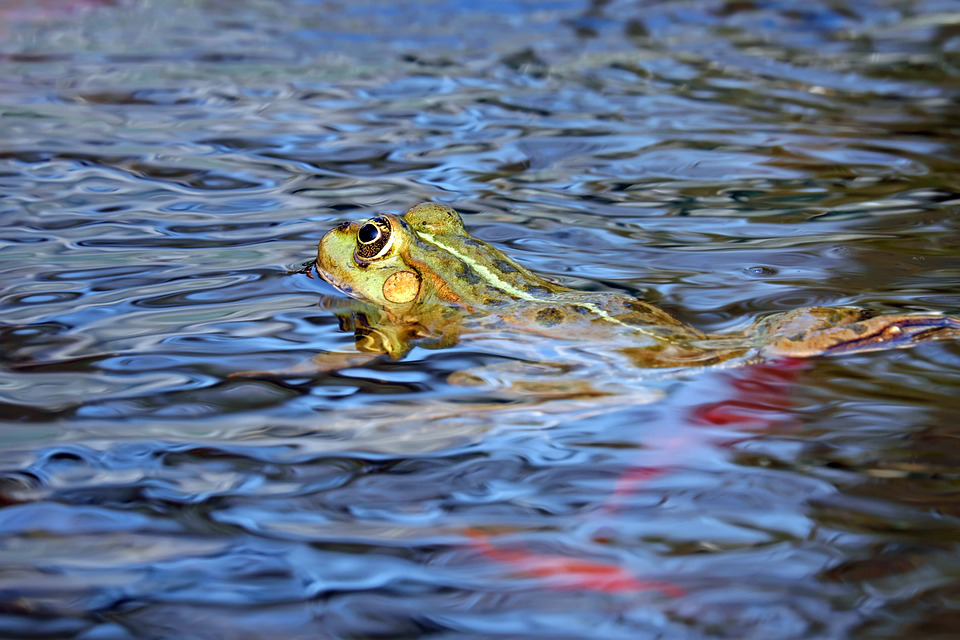

In [47]:
Image.open(absolute_image_paths[0]['animal pond'][5])

## Part 3 - AutoML

Use [TPOT](https://epistasislab.github.io/tpot/) to fit a predictive model for the King County housing data, with `price` as the target output variable.

In [48]:
!pip install tpot

In [49]:
import pandas as pd

url = "https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv"
df = pd.read_csv(url)

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


As with previous questions, your goal is to run TPOT and successfully run and report error at the end. Also, in the interest of time, feel free to choose small `generation=1`and `population_size=10` parameters, so your pipeline runs efficiently. You will want to be able to iterate and test. 

*Hint:* You will have to drop and/or type coerce at least a few variables to get things working. It's fine to err on the side of dropping to get things running - as long as you still get a valid model with reasonable predictive power. 

In [0]:
from sklearn.model_selection import train_test_split

X = df.drop(['price','date','id'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(
    X, df['price'].values, train_size=0.75, test_size=0.25)

In [0]:
from tpot import TPOTRegressor


In [53]:
%%time

tpot = TPOTRegressor(generations=1, population_size=10, verbosity=2)
tpot.fit(X_train, y_train)

Generation 1 - Current best internal CV score: -26052402928.37095

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=15, min_samples_split=11, n_estimators=100)
CPU times: user 3min 21s, sys: 3.72 s, total: 3min 25s
Wall time: 3min 21s


In [0]:
y_pred = tpot.predict(X_test)

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_pred, y_test))

In [56]:
print('Root Mean Square Error ($): ', rms)

Root Mean Square Error ($):  151317.7726407964


## Part 4 - More... 

Answer the following questions, with a target audience of a fellow Data Scientist:
* What do you consider your strongest area as a Data Scientist? 

I am passion in problem solving and it is the main task of a Data Sientist. To achieve this, we need to have a open mind since data is generated everywhere and different format. we also need to have logical thinking to turn all the unstructre data to meaninful information. This two cha·acteristics are exactly what I will describe my self.


* What area of Data Science would you most like to learn more about and why? 

Meachine learning is the area I like to foucs on. It is the cutting edge techology which can help to improve human life a lot in almost all aspect


* Where do you think Data Science will be in 5 years? 

Since Data Science has a breakthrough in the past 5 years. It is time to utilize what we have in real life application to improve our quality of life. More and more people can take advandage of AI to make our life more easily.


A few sentences per answer is fine. Only elaborate if time allows. Use markdown to format your answers.

Thank you for your hard, and congratulations!! You've learned a lot, and you should proudly call yourself a Data Scientist. 